In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from sklearn.cross_validation import KFold
from scipy import interpolate
from sklearn.model_selection import GridSearchCV
from astroML.datasets import fetch_great_wall
from sklearn.mixture import GMM
from astropy.table import Table
from astropy.table import vstack
from sklearn.neighbors import KernelDensity
import seaborn as sns
import pandas as pd
%matplotlib inline

/home/louis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Q2 
**a)** - Explain what feature extraction is and what considerations you should make when carrying it out for a classification/fitting task.


**Ans** - *Feature extraction* is defined as examining the characteristics of data points and focusing on the characteristic which infulence a fit or characterisation prediction of a data point. For fitting a model or a characterisation the problem of over fitting due large numbers of variables can be minimisied by feature extraction. This can be done using Principle Component Analysis (PCA). This is helpful in reducing computation times, as the number of variables are reduced. In this section the variables for each galaxy such as r_mag, r-i and i-z would be potentially more infulencial than g-r or u-g. By doing a PCA decomposition of the data we can show which are the most influential variables and which values could be combined to reduce the dimensionality.

In [2]:
file_path = 'FinalProject/Q2/Tables/'
fileA = 'PhotoZFileA.vot'
fileB = 'PhotoZFileB.vot'

data  = Table().read(file_path+fileA)

mag_r = data['mag_r']
ug = data['u-g']
gr = data['g-r']
ri = data['r-i']
iz = data['i-z']
z_spec = data['z_spec']

ok, = np.where(np.isfinite(mag_r) & np.isfinite(ug) & np.isfinite(gr) & np.isfinite(ri) & np.isfinite(iz)& np.isfinite(z_spec))

# This gymnastic can probably be avoided but works - this turns the table
# columns into honest-to-god ndarrays
mag_r = mag_r[ok].filled().data
ug = ug[ok].filled().data
gr = gr[ok].filled().data
ri = ri[ok].filled().data
iz = iz[ok].filled().data
z_spec = z_spec[ok].filled().data

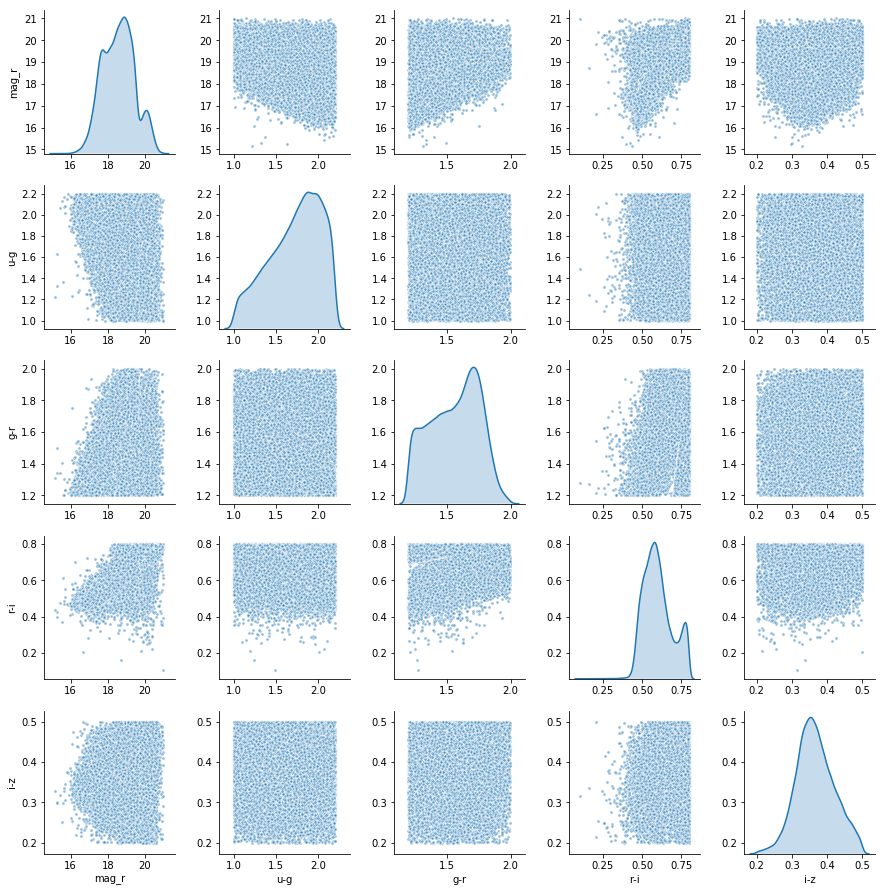

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.vstack([z_spec,mag_r,ug,gr,ri,iz])
M = np.vstack([mag_r,ug,gr,ri,iz])

df = pd.DataFrame(M.T, columns=('mag_r', 'u-g','g-r','r-i','i-z'))
sns.pairplot(df,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(alpha=0.5,s=10))
plt.savefig('PairPlot.png')
plt.show()

In [4]:
def var_plot(pca, ax=None, title=''):
    xtmp = np.arange(len(pca.explained_variance_))
    ytmp = pca.explained_variance_ratio_
    
    if ax is None:
        fig, ax = plt.subplot(111)
        
    ax.bar(xtmp, ytmp)
    ax.set_title(title)
    ax.set_xlabel('Component')
    return ax

[ 0.87769885  0.08558473  0.0284969   0.0042987   0.00267498  0.00124584]


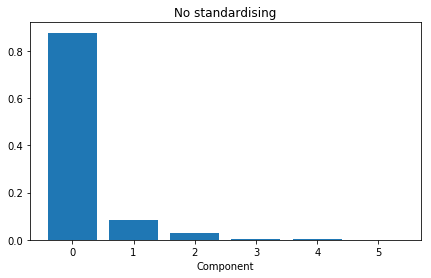

In [5]:
# shows the dependance of the principle components. 
pca = PCA(whiten=False, n_components=6)
pca.fit(X.T)
print(pca.explained_variance_ratio_)
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
var_plot(pca, axes, title='No standardising')
plt.savefig('PCA_variance.png')
plt.show()

## Q2
** b) ** - Here will look at Linear, Ridge and Lasso regression  to fit the a function $f(\theta)$ to z$_{spec}$ so that the following can be true:

 $$E(\theta) = median\Big(\Big|\frac{z_{spec} - f(\theta)}{1+z_{spec}}\Big|\Big) < 0.01 $$

In [6]:
# running_median function taken from:
# https://github.com/jbrinchmann/DDM2017/blob/master/Problemsets/Solution-ProblemSet1/Exploring%20Regression%20for%20problem%20set%20-%20solution.ipynb
# to trace out the medianed line of regression to give some sort of visualisation.


def running_median(x, y, N=10, binsize=None):
    """Calculate the median in N windows, or windows of size binsize.
    
    This ignores all edge effects - caveat emptor
    """

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # This finds the bins that each x should go in.
    # This is convenient for expanding the routine to accept other functions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    # I also want the x-positions in the bins. I use mean for that
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

The best-fit model is:
   Z_spec = -0.783+ 0.040r_mag + -0.013 (u-g) + 0.083 (g-r) + 0.416 (r-i) + 0.021 (i-z)


/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


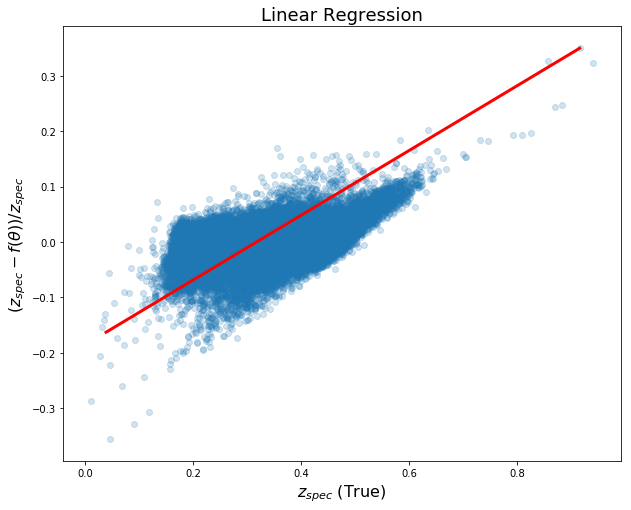

In [7]:
M = np.vstack([mag_r,ug,gr,ri,iz]).T

# Linear regression prediction
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
res = model_linear.fit(M,z_spec)
f_theta = model_linear.predict(M)
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]
print("The best-fit model is:\n   Z_spec = {0:.3f}+ {1:.3f}r_mag + {2:.3f} (u-g) + {3:.3f} (g-r) + {4:.3f} (r-i) + {5:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4],c[5]))



rel_err = (z_spec - f_theta)/(1+z_spec)
x_m_regular, med_regular, bins = running_median(z_spec, rel_err,N=20)
linex = [x_m_regular[1],x_m_regular[-1]]
liney = [med_regular[1], med_regular[-1]]
plt.figure(figsize=(10,8))
plt.plot(linex,liney, lw=3, color='red', label='Ridge regression')
plt.scatter(z_spec,rel_err,alpha =0.2)
plt.title('Linear Regression',size=18)
plt.xlabel(r'$z_{spec}$ (True)',size=16)
plt.ylabel(r'$(z_{spec}-f(\theta))/z_{spec}$',size=16)
plt.savefig('LinearRegression.png')
plt.show()
E_linear = np.median(np.abs((z_spec - f_theta)/(1.0+z_spec)))

In [8]:
from sklearn.linear_model import Ridge, Lasso

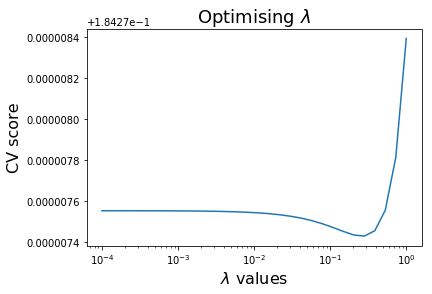

Optimal Alpha confirmed through k-fold Cross validation is 0.2807216203941176


In [9]:
# 'Kfold' adapted taken from:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#parameter-tuning-with-cross-validation
# more of a brute force method and a better result may be achieved using the Kfold routine from sklearn.

from sklearn.model_selection import cross_val_score
alphas = np.logspace(-4,0,num=30)
cv_scores =[]
for a in alphas:
    model_Ridge = Ridge(alpha=a,normalize=False)
    scores = cross_val_score(model_Ridge,M,z_spec,cv=10)
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]
plt.plot(alphas,MSE)
plt.title(r'Optimising $\lambda$',size=18)
plt.ylabel('CV score',size=16)
plt.xlabel(r'$\lambda$ values',size=16)
plt.xscale('log')
plt.savefig('optimal_lambda.png')
plt.show()

optimal_alpha = alphas[MSE.index(min(MSE))]
print('Optimal Alpha confirmed through k-fold Cross validation is {}'.format(optimal_alpha))

The best-fit model is:
   Z_phot = -0.784+ 0.040 r_mag + -0.013 (u-g) + 0.083 (g-r) + 0.415 (r-i) + 0.021 (i-z)


/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


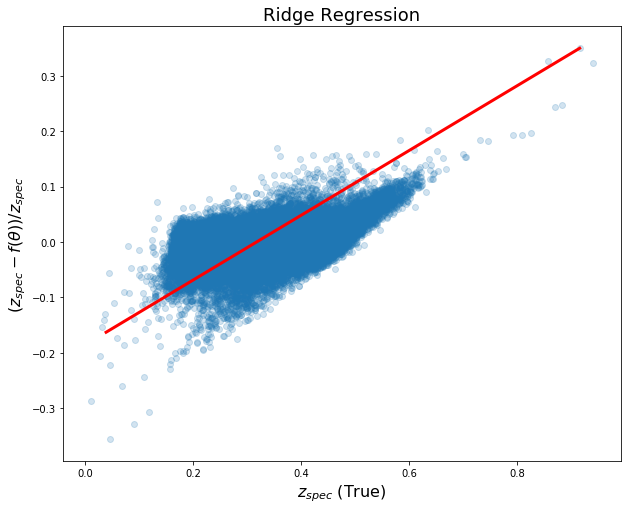

In [10]:
# ridge-regression calculation
model_Ridge = Ridge(alpha=optimal_alpha,normalize=False)
res = model_Ridge.fit(M,z_spec)
f_theta = model_Ridge.predict(M)
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]
print("The best-fit model is:\n   Z_phot = {0:.3f}+ {1:.3f} r_mag + {2:.3f} (u-g) + {3:.3f} (g-r) + {4:.3f} (r-i) + {5:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4],c[5]))

rel_err = (z_spec - f_theta)/(1+z_spec)
x_m_ridge, med_ridge, bins = running_median(z_spec, rel_err,N=20)
linex = [x_m_ridge[1],x_m_ridge[-1]]
liney = [med_ridge[1], med_ridge[-1]]

plt.figure(figsize=(10,8))
plt.plot(linex,liney, lw=3, color='red', label='Ridge regression')
plt.scatter(z_spec,rel_err,alpha =0.2)
plt.title('Ridge Regression',size=18)
plt.xlabel(r'$z_{spec}$ (True)',size=16)
plt.ylabel(r'$(z_{spec}-f(\theta))/z_{spec}$',size=16)
plt.savefig('RidgeRegression.png')
plt.show()
E_ridge = np.median(np.abs((z_spec - f_theta)/(1.0+z_spec)))

[ 0.03976858 -0.01210708  0.08260796  0.41518487  0.01770819]


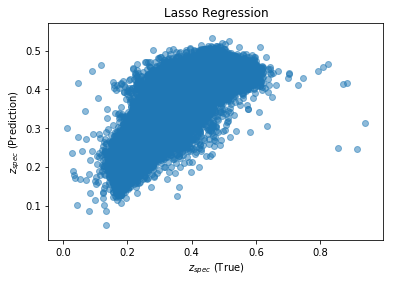

In [11]:
# lasso-regression calculation
model_lasso = Lasso(alpha=0.000001,normalize=True)
res = model_lasso.fit(M,z_spec)
f_theta = model_lasso.predict(M)
print(res.coef_)
plt.scatter(z_spec,f_theta,alpha =0.5)
plt.title('Lasso Regression')
plt.xlabel(r'$z_{spec}$ (True)')
plt.ylabel(r'$z_{spec}$ (Prediction)')
plt.savefig('LASSORegression.png')
plt.show()

In [12]:
E_lasso = np.median(np.abs((z_spec - f_theta)/(1.0+z_spec)))

In [13]:
E_array = np.array([E_lasso,E_ridge,E_linear])
E_names = ['Lasso','Ridge','Linear']
Models = [model_lasso,model_Ridge,model_linear]
print(E_array)
print(E_names)

[ 0.01457004  0.01455862  0.01455886]
['Lasso', 'Ridge', 'Linear']


In [14]:
min_val_index, = (np.where(E_array ==np.min(E_array)))
min_val = E_array[min_val_index]
min_name = E_names[int(min_val_index)]
model_A = Models[int(min_val_index)]
print('The Best Regression estimator is {} Regression with a value of {}'.format(min_name,np.round(min_val[0],8))) 

The Best Regression estimator is Ridge Regression with a value of 0.01455862



While this is the best estimator it still does not meet the requirements of as outlined above. Why this is the best could be due to the learn function $f(\theta)$ used, as trying to match the spectroscopic z magnitude by colour magnitudes is much different. This goes back to feature extraction, where the scientific question at hand is of importance.

*It has been later made known that the reason for this is that the file is corrupt* 

**C)** -Explain why the error estimated on the training sample is not a reliable estimate of the generalisation error of an estimator.  Use file B to quantify the generalisation error of the estimator you 
derived in problem b. 

In [15]:
# reading in the new data.

data  = Table().read(file_path+fileB)
mag_r = data['mag_r']
ug = data['u-g']
gr = data['g-r']
ri = data['r-i']
iz = data['i-z']
z_spec = data['z_spec']

ok, = np.where(np.isfinite(mag_r) & np.isfinite(ug) & np.isfinite(gr) & np.isfinite(ri) & np.isfinite(iz)& np.isfinite(z_spec))

# This gymnastic can probably be avoided but works - this turns the table
# columns into honest-to-god ndarrays
mag_r = mag_r[ok].filled().data
ug = ug[ok].filled().data
gr = gr[ok].filled().data
ri = ri[ok].filled().data
iz = iz[ok].filled().data
z_spec = z_spec[ok].filled().data

MB = np.vstack([mag_r,ug,gr,ri,iz]).T

f_theta=  model_A.predict(MB)
print(len(f_theta),len(z_spec)) #make sure the same lenght.
E_best_B = np.median(np.abs((z_spec - f_theta)/(1.0 + z_spec)))
print('For Best Regression estimator {} Regression an error value of {} was achieved'.format(min_name, np.round(E_best_B,8)))


74557 74557
For Best Regression estimator Ridge Regression an error value of 0.0146072 was achieved


**Comments - ** So here using the General error is larger than the training error, but still within the same range of error (only a difference of 0.0000485). A larger error can be expected as the error due to the training is biased as the points used were used to fit that specific data. The likeness of the error does however show that the robustness of the model

**d)** - Implement a photo-z estimator using the method of your choice from any of the regression methods discussed in the course, excluding the linear regression methods, e.g. k-nearest neighbours, 
random forests, neural networks, boosting methods,  but aim to get a lower generalisation error 
than your method derived in problem b. 

In [16]:
#reading in the training data
Train_data =  Table().read(file_path+fileA)

#setting the used data to variables
mag_r = Train_data['mag_r']
ug = Train_data['u-g']
gr = Train_data['g-r']
ri = Train_data['r-i']
iz = Train_data['i-z']
z_spec = Train_data['z_spec']

# conditioning as to where there is data i.e. no NaN values
ok, = np.where(np.isfinite(mag_r) & np.isfinite(ug) & np.isfinite(gr) & np.isfinite(ri) & np.isfinite(iz)& np.isfinite(z_spec))

# Getting rid of the data where there is no match.
mag_r = mag_r[ok].filled().data
ug = ug[ok].filled().data
gr = gr[ok].filled().data
ri = ri[ok].filled().data
iz = iz[ok].filled().data
z_spec = z_spec[ok].filled().data

# setting variables
train_data = np.vstack([mag_r,ug,gr,ri,iz]).T
train_target = z_spec

In [17]:
#reading in the test data
Test_data =  Table().read(file_path+fileB)

#setting the used data to variables
mag_r = Test_data['mag_r']
ug = Test_data['u-g']
gr = Test_data['g-r']
ri = Test_data['r-i']
iz = Test_data['i-z']
z_spec = Test_data['z_spec']

# conditioning as to where there is data i.e. no NaN values
ok, = np.where(np.isfinite(mag_r) & np.isfinite(ug) & np.isfinite(gr) & np.isfinite(ri) & np.isfinite(iz)& np.isfinite(z_spec))

# Getting rid of the data where there is no match.
mag_r = mag_r[ok].filled().data
ug = ug[ok].filled().data
gr = gr[ok].filled().data
ri = ri[ok].filled().data
iz = iz[ok].filled().data
z_spec = z_spec[ok].filled().data

# setting variables
test_data = np.vstack([mag_r,ug,gr,ri,iz]).T
test_target = z_spec


### **Bagging Regressor:**

This is the first of my models for which to imporove on the general error of the ridge regression. The bagging will use a knn regressor and will be optimised to number of nearest neighbours to use with 10 fold cross validation.

The Best number of Nearest Neighbours confirmed through k-fold Cross validation is 29.0


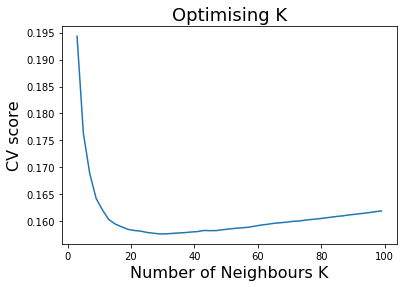

In [18]:
# Bagging Regressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import BaggingRegressor

# choosing the optimal number for k neighbours
all_neighbours = np.linspace(2,100,num=99)
neighbours = list(filter(lambda x: x % 2 != 0,all_neighbours))
cv_scores = []
for k in neighbours:
    knn = KNeighborsRegressor(n_neighbors=int(k), weights='uniform')
    scores = cross_val_score(knn,train_data,train_target,cv=10)
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]   
opt_neigh = neighbours[MSE.index(min(MSE))]
print('The Best number of Nearest Neighbours confirmed through k-fold Cross validation is {}'.format(opt_neigh))
plt.plot(neighbours,MSE)
plt.title('Optimising K',size=18)
plt.ylabel('CV score',size=16)
plt.xlabel('Number of Neighbours K',size=16)
plt.savefig('Optimal_KNN.png')
plt.show()

In [26]:
# bagging method adapted from:
# https://github.com/jbrinchmann/DDM2017/blob/master/Problemsets/EnsembleMethods/Examples%20of%20combining%20estimators.ipynb


n_est = 10
# Creating the classes
knn = KNeighborsRegressor(n_neighbors=int(opt_neigh), weights='distance')
bgr = BaggingRegressor(knn, n_estimators=n_est)

# making the model for baggage regression and doing the prediction for the training data
model_BagReg = bgr.fit(train_data,train_target)
f_bgr_train = model_BagReg.predict(train_data)

# looking at the test error to see if any improvement to the ridge regression. 
E_bgr_train = np.median(np.abs((train_target - f_bgr_train)/(1.0 + train_target)))
print('train error: {}'.format(E_bgr_train))

# now looking at the error for the test data to evaluate the general error.
f_bgr_test = model_BagReg.predict(test_data)
E_bgr_test = np.median(np.abs((test_target - f_bgr_test)/(1.0 + test_target)))
print('test error: {}'.format(E_bgr_test))


###
# error for distance
# train error: 0.004039679336329849
# test error: 0.012425903050854115

# error for uniform
# train error: 0.011919097204074768
# test error: 0.012490041201236101


train error: 0.004039679336329849
test error: 0.012425903050854115


/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


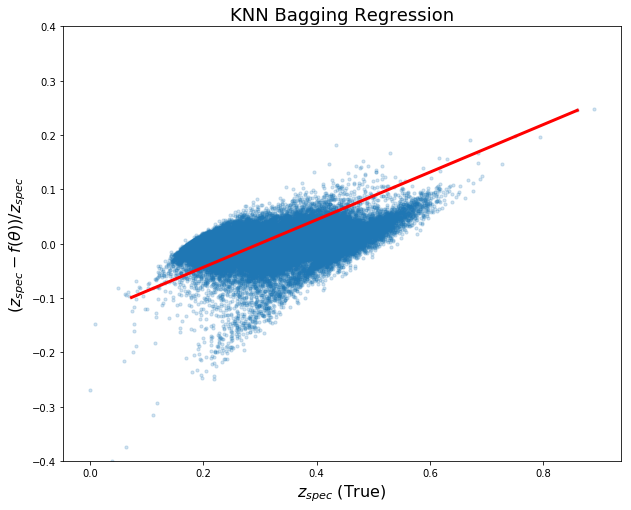

In [34]:
rel_err_BagKNN = (test_target - f_bgr_test)/(1.0 + test_target)
x_m_bk, med_bk, bins = running_median(test_target, rel_err_BagKNN,N=20)
linex = [x_m_bk[2],x_m_bk[-1]]
liney = [med_bk[2], med_bk[-1]]

plt.figure(figsize=(10,8))
plt.plot(linex,liney, lw=3, color='red', label='Ridge regression')
plt.scatter(test_target,rel_err_BagKNN,alpha =0.2,s=10)
plt.title('KNN Bagging Regression',size=18)
plt.xlabel(r'$z_{spec}$ (True)',size=16)
plt.ylabel(r'$(z_{spec}-f(\theta))/z_{spec}$',size=16)
plt.savefig('BaggedKNNRegression.png')
plt.ylim(-0.4,0.4)
plt.show()

**Comments - ** Immediately there is an imporvement and the number of layers used for the bagging technique must be justified, but use of 10 seems sufficient. 

### **Ada Boosted KNN:**

This is the second of my models for which to imporove on the general error of the ridge regression.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# Creating the Classes
knn = KNeighborsRegressor(n_neighbors=int(opt_neigh), weights='uniform')
knn_boost = AdaBoostRegressor(knn, n_estimators=10)

# making the model for baggage regression and doing the prediction for the training data
model_boost_knn = knn_boost.fit(train_data, train_target)
f_boost_knn_train = model_boost_knn.predict(train_data)

# looking at the test error to see if any improvement to the ridge regression. 
E_boost_knn_train = np.median(np.abs((train_target - f_boost_knn_train)/(1.0 + train_target)))
print('train error: {}'.format(E_boost_knn_train))

# now looking at the error for the test data to evaluate the general error.
f_boost_knn_test = model_boost_knn.predict(test_data)

E_boost_knn_test = np.median(np.abs((test_target - f_boost_knn_test)/(1.0 + test_target)))
print('test error: {}'.format(E_boost_knn_test))

**comments -** initial comments is that for n_est=100 the process is very time consuming. This may be worth it dpending on results, similar to bagging must consider and justify choice of weights, n_estimators and n_neighbours

### Random Forest

This is a combination of bagging with decision trees  

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Creating the Classes
ran_forest = RandomForestRegressor(n_estimators=10, criterion='mae')

# making the model for baggage regression and doing the prediction for the training data
model_ran_for = ran_forest.fit(train_data, train_target)
f_ran_for_train = model_ran_for.predict(train_data)

# looking at the test error to see if any improvement to the ridge regression. 
E_ran_for_train = np.median(np.abs((train_target - f_ran_for_train)/(1.0 + train_target)))
print('train error: {}'.format(E_ran_for_train))

# now looking at the error for the test data to evaluate the general error.
f_ran_for_test = model_ran_for.predict(test_data)

E_ran_for_test = np.median(np.abs((test_target - f_ran_for_test)/(1.0 + test_target)))
print('test error: {}'.format(E_ran_for_test))

**comments** In this one the use of criterion='mae' is justified such that it will not be as sensitive to outliers. (mae = Mean Absolute Error), but number of estimators still needs to be justified.